### FactRuEval example

In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

### 0. Download pretrained bert model
Download pretrained bert [here](https://storage.googleapis.com/bert_models/2018_11_03/multilingual_L-12_H-768_A-12.zip) and unzip.

Use the following code for convert tensorflow model to pytorch:


```export BERT_BASE_DIR=/path/to/bert/multilingual_L-12_H-768_A-12```

```python3 convert_tf_checkpoint_to_pytorch.py \```

```  --tf_checkpoint_path $BERT_BASE_DIR/bert_model.ckpt \ ```

```  --bert_config_file $BERT_BASE_DIR/bert_config.json \```

```  --pytorch_dump_path $BERT_BASE_DIR/pytorch_model.bin```

In [14]:
import os


data_path = "/home/lis/ner/ulmfit/data/factrueval/"
train_path = os.path.join(data_path, "train_with_pos.csv")
valid_path = os.path.join(data_path, "valid_with_pos.csv")
model_dir = "/datadrive/models/multilingual_L-12_H-768_A-12/"
init_checkpoint_pt = "/datadrive/models/multilingual_L-12_H-768_A-12/pytorch_model.bin"
bert_config_file = os.path.join(model_dir, "bert_config.json")
vocab_file = os.path.join(model_dir, "vocab.txt")

In [15]:
import torch
torch.cuda.set_device(1)
torch.cuda.is_available(), torch.cuda.current_device()

(True, 1)

### 1. Data preparation

Data train and validation should be presented in the following format.

In [16]:
import pandas as pd


df = pd.read_csv(train_path)
df.head()

,0,1,3
0,O O O O O O O O O O O O O O O O O O O O,"Мифология солнцеворота , собственно , и сводит...",NOUN NOUN PNCT ADVB PNCT CONJ VERB PREP NOUN N...
1,O O O O O O B_ORG I_ORG O B_ORG I_ORG O O O O ...,"По его словам , с покупкой Caramba TV « СТС Ме...",PREP NPRO NOUN PNCT PREP NOUN <unk> <unk> PNCT...
2,O O O O O O O O O O O O O O O O B_LOC O,"Такое десятилетие , по его словам « необходимо...",ADJF NOUN PNCT PREP NPRO NOUN PNCT ADJS ADJF P...
3,O O O O O O O O O O O O O O,"Правительство уволило часть врачей , обвинив и...",NOUN VERB NOUN NOUN PNCT GRND NPRO PREP NOUN N...
4,O O O B_PER I_PER O O O O O O B_ORG I_ORG I_OR...,Министр сельского хозяйства Николай Федоров пр...,NOUN ADJF NOUN NOUN NOUN VERB PNCT CONJ PRTF V...


Train and valid .csv files must have columns named (0, 1). Column 3 is't necessary (does not used now).
* Column 0 contains labels in IOB format.
* Column 1 contains tokenized and separated (by whitespace) text.

For using data in model we need to create `NerData` object.

* `train_path` - path to train .csv file
* `valid_path` - path to valid .csv file
* `vocab_file` - path to google bert pretrained vocab
* `batch_size` - batch size (default `16`)
* `cuda` - using cuda or cpu (default `True`)
* `is_cls` - create data for joint model (default `False`)

In [18]:
from modules import NerData

In [26]:
data = NerData.create(train_path, valid_path, vocab_file)

For factrueval we use the following sample of labels:

In [28]:
print(data.label2idx)

{'<pad>': 0, '[CLS]': 1, '[SEP]': 2, 'B_O': 3, 'I_O': 4, 'B_ORG': 5, 'I_ORG': 6, 'B_LOC': 7, 'I_LOC': 8, 'B_PER': 9, 'I_PER': 10}


### 2. Create model
For creating pytorch model we need to create `NerModel` object.

Pretrained params:
* `bert_config_file` - path to google bert pretrained config
* `init_checkpoint_pt` - path to google bert pretrained weights(?)
* `freeze_enc` - freezing bert encoder (default `True`)
* `bert_mode` - mode of how bert output will be returned. If `last` return the output of last layer. If `weighted` return weighted sum of all bert output layers, weights are learnable (aka ELMO).

Decoder params:
* `tag_size` - number of labels: `len(data.id2label)`
* `embedding_dim` - output dim from encoder (default `768`)
* `dropout_ratio` - dropout param (default `0.4`)
* `use_hidden` - using linear layer after lstm (default `True`)
* `use_rnn` - using rnn (default `True`)
* `hidden_dim` - dim of rnn layer or hidden layer (default `128`)
* `rnn_layers` - number of rnn layers (default `1`)

MultiheadAttention Layer params
* `num_heads` - number of heads (default `3`)
* `dropout_attn` - dropout for atention (default `0.1`)
* `key_dim` - keyword dim in attention (default `64`)
* `val_dim` - value dim (default `64`)
* `use_attn` - include attention layer to model (defalut `False`) 

Gpu or cpu:
* `use_cuda` - use cuda or cpu (default `True`).

In [29]:
from modules import NerModel

In [30]:
model = NerModel.create(bert_config_file, init_checkpoint_pt, 11, use_rnn=True, use_attn=True,
                        bert_mode="weighted")

Use rnn of type: lstm with n_layers: 1
Use MultiHeadAttention layer with num_heads 3
Use fully-connected layer before crf.
freeze_encoder


### 3. Create learner

For training our pytorch model we need to create `NerLearner` object.

* `model: NerModel` - pytorch model
* `sup_labels` - list of supported labels for calculating f1 metric. For FactRuEval use: `['B_LOC', 'I_LOC', 'B_ORG', 'I_ORG', 'B_PER', 'I_PER']`
* `base_lr` - starting learning rate (default `0.001`)
* `lr_max` - max learning rate for scheduler (default `0.01`)
* `betas` - params for default optimizer (default `[0.8, 0.9]`)
* `clip` - grad clipping (default `0.25`)
* `verbose` - printing to console reports (default `True`)

In [35]:
from modules import NerLearner

In [36]:
learner = NerLearner(model, data.id2label[5:], data,
                     best_model_path="/datadrive/models/factrueval/exp_attn2.cpt",
                     base_lr=0.001, lr_max=0.01, clip=5.0, use_lr_scheduler=True)

INFO:root:Use lr OneCycleScheduler...


### 4. Learn your NER model
Call `learner.fit`
* `epochs` - number of train iterations (default `100`)
* `resume_history` - resuming appending results to history or create new (default `True`)
* `target_metric` - mean metric, that want you see to pick best epochs (default `f1`).

In [37]:
learner.fit(2, target_metric='prec')

INFO:root:Resuming train... Current epoch 0.


INFO:root:
lr after epoch: 0.0032403433476394846
INFO:root:
epoch 1, average train epoch loss=461.14



INFO:root:on epoch 0 by max_prec: 0.8329999999999999
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       [CLS]      1.000     1.000     1.000       415
       [SEP]      1.000     1.000     1.000       415
       B_LOC      0.854     0.535     0.658       230
       I_LOC      0.828     0.603     0.697       239
         B_O      0.972     0.980     0.976      7203
         I_O      0.952     0.977     0.964      5148
       B_ORG      0.711     0.683     0.697       543
       I_ORG      0.750     0.708     0.729       614
       B_PER      0.943     0.922     0.932       321
       I_PER      0.912     0.946     0.928       480

   micro avg      0.945     0.945     0.945     15608
   macro avg      0.892     0.835     0.858     15608
weighted avg      0.943     0.945     0.943     15608



INFO:root:
lr after epoch: 0.005490343347639485
INFO:root:
epoch 2, average train epoch loss=195.51



INFO:root:on epoch 0 by max_prec: 0.8329999999999999


              precision    recall  f1-score   support

       [CLS]      1.000     1.000     1.000       415
       [SEP]      1.000     1.000     1.000       415
       B_LOC      0.781     0.465     0.583       230
       I_LOC      0.780     0.757     0.769       239
         B_O      0.963     0.981     0.972      7203
         I_O      0.971     0.971     0.971      5148
       B_ORG      0.730     0.689     0.709       543
       I_ORG      0.780     0.761     0.770       614
       B_PER      0.944     0.941     0.942       321
       I_PER      0.931     0.952     0.941       480

   micro avg      0.947     0.947     0.947     15608
   macro avg      0.888     0.852     0.866     15608
weighted avg      0.945     0.947     0.946     15608



In [41]:
from modules.utils.plot_metrics import plot_by_class_curve

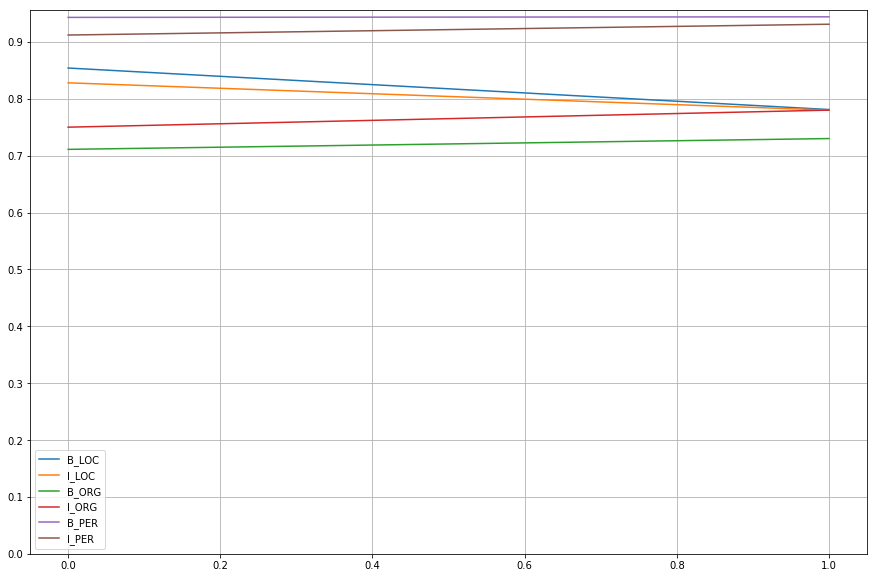

In [42]:
plot_by_class_curve(learner.history, 'prec', data.id2label[5:])

### 5. Predict on new data
Create new data loader from existing path.

In [43]:
from modules.data.data import get_data_loader_for_predict

In [44]:
dl, orig_to_tok_map = get_data_loader_for_predict(data_path+"valid.csv", learner)

Load our best model.

In [45]:
learner.load_model()

Call predict from learner.

In [46]:
preds = learner.predict(dl)

### 6. Transform predictions to tokens and spans

In [49]:
from modules.utils.utils import to_words, tokens2spans


tokens, labels = to_words(dl, orig_to_tok_map, preds)

In [50]:
spans = tokens2spans(tokens, labels)

In [51]:
print(tokens[0])

['сделка', 'состоится', ',', 'если', 'будет', 'одобрена', 'регуляторами', ',', 'из-за', 'которых', 'в', 'начале', 'года', 'сорвалось', 'слияние', 'nyse', 'euronext', 'с', 'deutsche', 'borse']


Predicted labels

In [52]:
print(labels[0])

['B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_ORG', 'B_ORG', 'B_O', 'B_ORG', 'B_ORG']


Origin labels

In [53]:
tokens, labels = to_words(dl, orig_to_tok_map, [x.labels for x in dl.dataset])

In [54]:
print(labels[0])

['B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_ORG', 'B_ORG', 'B_O', 'B_ORG', 'B_ORG']


Predicted spans

In [55]:
print(spans[0])

[('сделка', 'O'), ('состоится', 'O'), (',', 'O'), ('если', 'O'), ('будет', 'O'), ('одобрена', 'O'), ('регуляторами', 'O'), (',', 'O'), ('из-за', 'O'), ('которых', 'O'), ('в', 'O'), ('начале', 'O'), ('года', 'O'), ('сорвалось', 'O'), ('слияние', 'O'), ('nyse', 'ORG'), ('euronext', 'ORG'), ('с', 'O'), ('deutsche', 'ORG'), ('borse', 'ORG')]


Origin spans

In [56]:
spans = tokens2spans(tokens, labels)

In [57]:
print(spans[0])

[('сделка', 'O'), ('состоится', 'O'), (',', 'O'), ('если', 'O'), ('будет', 'O'), ('одобрена', 'O'), ('регуляторами', 'O'), (',', 'O'), ('из-за', 'O'), ('которых', 'O'), ('в', 'O'), ('начале', 'O'), ('года', 'O'), ('сорвалось', 'O'), ('слияние', 'O'), ('nyse', 'ORG'), ('euronext', 'ORG'), ('с', 'O'), ('deutsche', 'ORG'), ('borse', 'ORG')]


In [59]:
from modules.utils.plot_metrics import get_span_report
clf_report = get_span_report(dl, orig_to_tok_map, preds)
print(clf_report)

              precision    recall  f1-score   support

         ORG      0.701     0.657     0.679       543
         LOC      0.861     0.539     0.663       230
         PER      0.927     0.907     0.917       321

   micro avg      0.798     0.706     0.749      1094
   macro avg      0.830     0.701     0.753      1094
weighted avg      0.801     0.706     0.745      1094



### 7. Fit factrueval for best metric

In [415]:
model = NerModel.create(bert_config_file, init_checkpoint_pt, len(data.id2label), hidden_dim=128)

freeze_encoder


In [416]:
learner = NerLearner(
    model,
    data.id2label[5:],
    data,
    lr=0.001,
    clip=5.0,
    best_model_path="/datadrive/models/factrueval/best_model.cpt")

11/20/2018 15:35:40 - INFO - root -   Don't use lr scheduler...


In [ ]:
learner.fit(300, target_metric='prec')

### 8. Evaluate
Note: The following result can be improved!

In [422]:
dl, orig_to_tok_map = get_data_loader_for_predict(data_path+"valid.csv", learner)
learner.load_model()
preds = learner.predict(dl)

#### Evaluate tokens

In [423]:
from modules.utils.plot_metrics import *

In [437]:
get_mean_max_metric(learner.history, data.id2label[5:], "prec", True)

(63, 0.9341666666666667)

#### Evaluate spans

In [431]:
from modules.plot_metrics import get_span_report

In [433]:
clf_report = get_span_report(dl, orig_to_tok_map, preds)

In [434]:
print(clf_report)

              precision    recall  f1-score   support

         LOC      0.885     0.504     0.643       230
         ORG      0.898     0.727     0.804       543
         PER      0.928     0.888     0.908       321

   micro avg      0.907     0.728     0.807      1094
   macro avg      0.904     0.707     0.785      1094
weighted avg      0.904     0.728     0.800      1094

